In [205]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import random
import time
import pickle
import sys
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sys.setrecursionlimit(50000)


### Loading & Modifying the DataFrame to Include additional columns

In [298]:
df_movies = pd.read_csv('Movies_listv3.csv',parse_dates=[7])

df_movies['Year'] = df_movies['Release Date'].dt.year
df_movies.rename(columns={'Franchise Ranking':'Franchise','Brand Ranking':'Brand'},inplace=True)

print(df_movies.shape)
print(df_movies.columns)

# df_movies.dtypes

#Target Variable
y = 'Opening Weekend Gross'


(6280, 18)
Index(['Release Link', 'Title', 'Domestic Gross', 'Max Theatres',
       'Opening Weekend Gross', 'Domestic to Opening Gross',
       'Opening Weekend Theatres', 'Release Date', 'Studio Link',
       'Studio Name', 'Title ID', 'Running Length', 'Budget', 'MPAA', 'Genre',
       'Franchise', 'Brand', 'Year'],
      dtype='object')


### Exploratory Data Analysis

In [299]:
df_movies.Budget.isna().sum()

4212

0.0    5854
1.0     426
Name: Franchise, dtype: int64

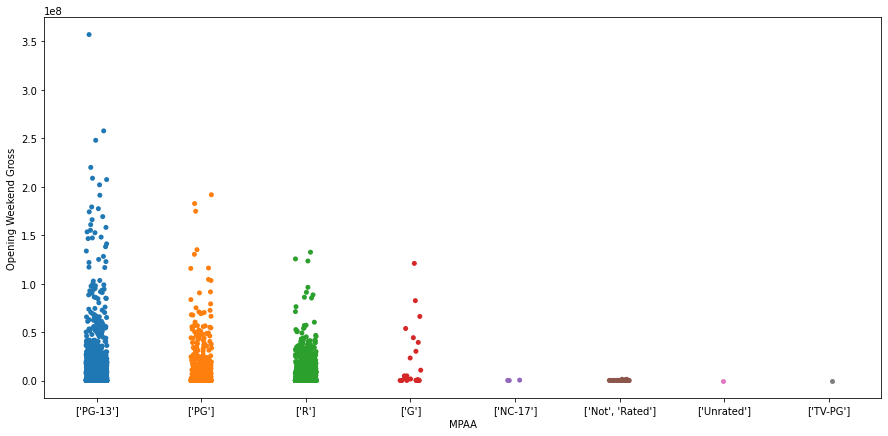

In [295]:
# df_movies.MPAA.unique()

# df_movies.describe()
plt.figure(figsize=(15,7))
sns.stripplot(x='MPAA',y='Opening Weekend Gross',data=df_movies)
# df_movies['Studio Name'].unique()

# values = item for item in df_movies.Genre.fillna([[]]).unique()]
# df_movies.Genre.fillna()

df_movies.Franchise.value_counts()

### Encoding Studio Column

The top 6 distribution studios that are most common today are encoded to the number '1' under a new column named **'Big_Studio'**. If the studio is not one of these, it is encoded to 0. 
These 6 make up almost 80% of the market share in Domestic Gross Revenue. Morever, there is a huge cliff dropoff in the market share between the 6th & 7th ranking studio (in terms of cumulative Gross Revenue).
The idea is that these bigger studios have a greater capacity to market their movies, which will help achieve a higher opening weekend revenue.   
The list of top 6 studios were taken from the site [here](https://www.the-numbers.com/market/distributors)  

The top 6 studios are:  
Walt Disney Studios Motion Pictures  
Warner Bros.  
Sony Pictures Entertainment (SPE)  
Universal Pictures  
Twentieth Century Fox  
Paramount Pictures

<AxesSubplot:xlabel='Big_Studio', ylabel='Opening Weekend Gross'>

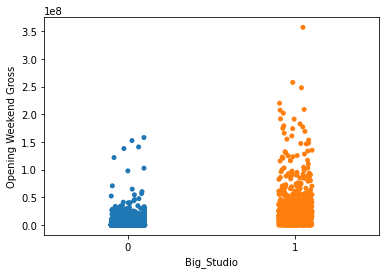

In [300]:
big_studios = ['Walt Disney Studios Motion Pictures', 'Warner Bros.', \
               'Sony Pictures Entertainment (SPE)', 'Universal Pictures', \
               'Twentieth Century Fox', 'Paramount Pictures']

df_movies['Big_Studio'] = df_movies['Studio Name'].map(lambda x:1 if x in big_studios else 0)

df_movies.head(10)

df_movies[df_movies.Big_Studio == 0].sort_values(by=y,ascending=False).head(15)

sns.stripplot(x='Big_Studio',y=y,data=df_movies)

### Encoding the MPAA Rating

If the movie has a PG-13 or PG rating, it is encoded to a value of 2, else if it has a value of 'R', it is encoded to 1, else it is given a value of 0; in a new column named **'MPAA Code'**  
The thought here is that the former allows for family with kids viewing, providing access to a greater share of potential audience, while the later is restricted in terms of the audience it can tap into.

In [259]:
df_movies.MPAA.unique()

array(["['PG-13']", "['PG']", nan, "['R']", "['G']", "['NC-17']",
       "['Not', 'Rated']", "['Unrated']", "['TV-PG']"], dtype=object)

In [248]:
a = np.nan
' '.join(a)

TypeError: can only join an iterable

In [265]:
# Map MPAA rating to 2's, 1's & 0's
# df_movies[df_movies.notnull()].MPAA.apply(' '.join)

# [','.join(map(str, l)) for l in df_movies[df_movies.notnull()].MPAA]

# df_mpaa = pd.Series(index=df_movies.MPAA.unique(),dtype=int)
[' '.join(map(str, l)) for l in df_movies.MPAA.fillna(value='Unknown')]
# mpaa_map = dict()
# df_mpaa

["[ ' P G - 1 3 ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G ' ]",
 'U n k n o w n',
 "[ ' P G ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G ' ]",
 "[ ' R ' ]",
 "[ ' P G ' ]",
 "[ ' P G ' ]",
 "[ ' P G ' ]",
 "[ ' P G ' ]",
 "[ ' R ' ]",
 "[ ' R ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' R ' ]",
 "[ ' R ' ]",
 "[ ' R ' ]",
 "[ ' R ' ]",
 "[ ' R ' ]",
 "[ ' P G ' ]",
 "[ ' R ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' R ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' R ' ]",
 "[ ' P G ' ]",
 "[ ' R ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' R ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' R ' ]",
 "[ ' R ' ]",
 "[ ' P G - 1 3 ' ]",
 "[ ' R 

### Encoding the Release Dates

There are two approaches that will be taken to encode the release dates.  
The first is creating a column named **'Release_Season'**.  
November, December, May, June & July are known as blockbuster seasons, when tentpole movies with higher commercial expectations are released. Whereas, Jan, Feb, Aug, Sep are known as 'dump seasons'. So, 'Release_season' column will encode a 2 for the blockbuster season months, 0 for the dump season months and a 1 for the remaining months.  
#### Might do the below part. After MVP
Secondly, all dates that are part of a holiday weekend will be encoded as a 1 in a separate column named 'Holiday_Weekend'. The expectation is that holiday weekends generally draw larger crowds, contributing to higher grosses.   
An external dataset is used to generate all holidays for the last 10 years. 
Scrape holiday from [here](https://www.timeanddate.com/holidays/us/2020?hol=1)

<AxesSubplot:xlabel='Release_Season', ylabel='Opening Weekend Gross'>

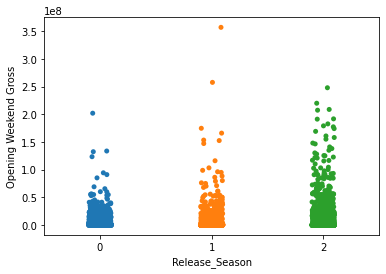

In [301]:
# Encode date to month seasonality columns
release_month_category_map = {1:0,2:0,3:1,4:1,5:2,6:2,7:2,8:0,9:0,10:1,11:2,12:2}
# df_movies['Release Date'].dt.month.map(release_month_category_map)

df_movies['Release_Season'] = df_movies['Release Date'].dt.month.map(release_month_category_map)
# df_movies
sns.stripplot(x='Release_Season',y='Opening Weekend Gross',data=df_movies)

df_movies.

### Studio scraping

May use below code block to encode studios based on per year instead of just using the aggregate big 6 studios.  
Can also create a rolling 12 total for biggest studios from prior year, based off release date.

In [114]:
top_10_distributors = dict()
# top_10_dis = list()
for year in range(2010,2020,1):
    distributors_url = 'https://www.the-numbers.com/market/{}/distributors'

    response = requests.get(distributors_url.format(year))
    
    distributors_soup = BeautifulSoup(response.text,'html5lib')
    dist = distributors_soup.find(text=re.compile("Top Grossing")).findParent().findNext().find_all('tr')[1:11]
    
    for row in dist:
        top_10_distributors['year'] = year
        top_10_distributors['Distributor'] = row.find_all('td')[1].text
        top_10_distributors['Link'] = row.find_all('td')[1].find('a').get('href')
        top_10_distributors['Gross'] = row.find_all('td')[3].text
        
top_10_dis
top_10_distributors

{'year': 2019,
 'Distributor': 'Focus Features',
 'Link': '/market/2019/distributor/Focus-Features',
 'Gross': '$210,049,942'}

In [ ]:
# Possibly summing values from the studio grosses for last 2 years

print(df_movies.groupby(['year','Studio Name'])['Domestic Gross'].agg(['sum','mean']).sort_values(by=['year','mean'],ascending=False))